# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('once')
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

E:\anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
E:\anaconda\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [12]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [13]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display


In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]



In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

        

8
What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple suddenly get caught inside of a  &quot;broken-up&quot; bridge and then just before they start to tumble down  into the lake, a board catches them.  But just when they've got their hopes  up, and small dog steps on the board and the car starts to slide off the  bridge and into the lake waters.  A few minutes later...<p>They find  themselves back into their home, they find that somehow somehad light the  fireplace, as if done by magic.  From then on, they find a weird-looking  dead guy known as Bettlejuice.  The only way they can get him for help is  to call him by his name three times and he will appear at their survice.  But they soon wish that they have never called his name, because  Bettlejuice was once a troublemaker but he is the only one who can save  them, on the account that they said his 

In [2]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'any', 'in', 'should', 'whom', "you'll", 'couldn', 'was', 'between', 'who', 'wasn', "haven't", 'having', 'aren', 'needn', 'so', 'for', 'this', "needn't", 'other', "doesn't", 'yourselves', 'hers', "couldn't", 'i', 'theirs', 'out', 'ma', 'him', 'such', "hasn't", 'each', 'what', "won't", "don't", 'from', 'myself', 'they', 'shan', 'but', 'not', 'with', 'above', 'hasn', 'doesn', 'no', 'more', 'your', 'does', 'same', 'their', 'than', 'can', "it's", 'about', 'while', 'an', 'up', 'then', 'during', 'yourself', 'some', 'off', 'being', 'how', 'by', 'did', "she's", 'we', 'against', 'when', 'she', 'very', 'have', 'mightn', 'do', "weren't", 'yours', "isn't", 'he', 'been', 'why', 'isn', 'through', 'it', 'to', 'shouldn', 'had', 'ours', 'at', "you'd", 'ourselves', 'weren', "should've", 'own', 'the', 'most', "aren't", 'those', 'mustn', 're', "you're", 'where', "mightn't", 'me', 'you', 'herself', 've', 'be', 'hadn', 'just', 'as', 'because', 'nor', 'before', 'ain', 's', 'of', 'my', 'his', 'down', 'its', 

E:\anaconda\lib\site-packages\nltk\corpus\reader\wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='C:\\Users\\Abhinav Singh\\AppData\\Roaming\\nltk_data\\corpora\\stopwords\\english'>
  return concat([self.open(f).read() for f in fileids])


In [17]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [18]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [ ]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [3]:
con = sqlite3.connect('final.sqlite')
final = pd.read_sql_query('SELECT * FROM Reviews',con)

from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
def values(x):
    if x == 'positive':
        return 1
    return 0
X = final['Text'].values
label = final['Score']
Y = label.map(values)

## Test data split ##
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=0.3, random_state=0)

# Bag of Words (BoW)

In [16]:
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(X_train)
final_counts = preprocessing.MaxAbsScaler().fit_transform(final_counts)

In [4]:
X_test_counts = count_vect.transform(X_test)
X_test_counts = preprocessing.MaxAbsScaler().fit_transform(X_test_counts)

### Finding the value of  C for logistic regression with l1 regularization using grid and random search

In [8]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings 
warnings.filterwarnings('ignore')
logisticregression = LogisticRegression(penalty='l1')
l1_values = [{'C': [10**-5,10**-4,10**-3,10**-2, 10**0, 10**2,10**-3,10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l1'), l1_values, scoring = 'f1', cv=10)
model.fit(final_counts[0:20000], Y_train[0:20000])
print(model.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
param_dist = {'C': [10**-5,10**-4,10**-3,10**-2, 10**0, 10**2,10**-3,10**4]}
model = RandomizedSearchCV(LogisticRegression(penalty='l1'), param_dist, scoring = 'f1', cv=10,n_iter=2)
model.fit(final_counts[0:20000], Y_train[0:20000])
print(model.best_estimator_)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


### Sparsity in weight vector due to L1 regularization

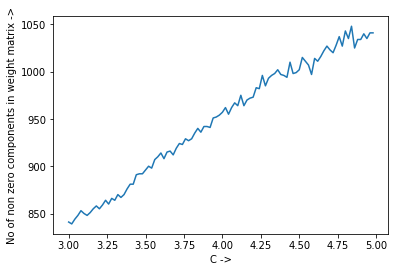

In [15]:
from sklearn.cross_validation import cross_val_score
values =list(np.arange(3,5,0.02))
cv_score =[]
weights =[]
for lambdaa in values:
    lr = LogisticRegression(C=lambdaa , penalty='l1')
    lr.fit(final_counts[0:5000],Y_train[0:5000])
    weights.append(np.count_nonzero(lr.coef_))
plt.plot(values,weights)
plt.xlabel('C ->')
plt.ylabel('No of non zero components in weight matrix ->')
plt.show()

Observations : The above graph clearly shows as the value of C increases the sparsity of weight matrix decreases and vice versa

### Finding the best value of C for logistic regression with l2 regularization using grid and random search

In [17]:
# Using grid search
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')
logisticregression = LogisticRegression(penalty='l1')
l1_values = [{'C': [10**-5,10**-4,10**-3,10**-2, 10**0, 10**2,10**-3,10**4]}]
model = GridSearchCV(logisticregression, l1_values, scoring = 'f1', cv=10)
model.fit(final_counts[0:20000], Y_train[0:20000])
print(model.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [17]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
param_dist = {'C': [10**-5,10**4]}
model = RandomizedSearchCV(LogisticRegression(penalty='l2'), param_dist, scoring = 'f1', cv=10,n_iter=2)
model.fit(final_counts[0:20000], Y_train[0:20000])
print(model.best_estimator_)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


### sparsity in weight matrix due to L2 regularization

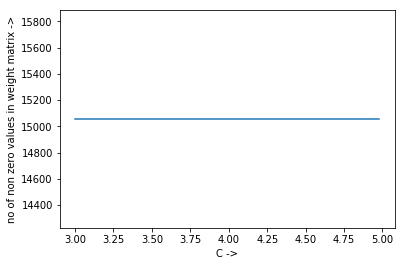

In [19]:
from sklearn.cross_validation import cross_val_score
values =list(np.arange(3,5,0.02))
cv_score =[]
weights =[]
for lambdaa in values:
    lr = LogisticRegression(C=lambdaa , penalty='l2')
    lr.fit(final_counts[0:5000],Y_train[0:5000])
    weights.append(np.count_nonzero(lr.coef_))
plt.plot(values,weights)
plt.xlabel('C ->')
plt.ylabel('no of non zero values in weight matrix ->')
plt.show()

### Multicollinearity check

Observation : L2 regularization does not affects the sparsity of weight matrix

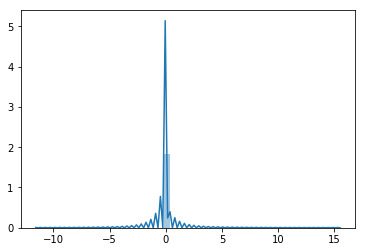

In [34]:
mat = np.random.normal(loc=0.1,scale = 0.1 ,size=1000)
mat = mat.reshape(1000,1)
lcheck = LogisticRegression(C=4.96,penalty='l1')
lcheck.fit(final_counts[0:1000],Y_train[0:1000])
lcheck = LogisticRegression(C=4.96,penalty='l1')
lcheck.fit(final_counts[0:1000],Y_train[0:1000])
noise = final_counts[0:1000] + mat
lcheck1 = LogisticRegression(C=4.96,penalty='l1')
lcheck1.fit(noise,Y_train[0:1000])
w1 = np.array(lcheck.coef_)
w2 = np.array(lcheck1.coef_)
weight = np.subtract(w1,w2)
weight = pd.DataFrame(data=weight.T,index=None)
sns.distplot(a=weight,kde=True)
plt.show();

Observation : The difference between weights of original data and data with noise seems very less as all the points in histogram lie almost close to zero i.e the data does not suffer from multicolinearity

In [60]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
logisticclassifier = LogisticRegression(C=4.86,penalty='l1')
logisticclassifier.fit(final_counts[0:90000],Y_train[0:90000])
y_predicted = logisticclassifier.predict(X_test_counts[0:10000])
score = accuracy_score(y_predicted,Y_test[0:10000])
con = confusion_matrix(Y_test[0:10000],y_predicted)
print('accuracy on test data: ',score*100,"%")
print('confusion matrix')
print(con)

accuracy on test data:  90.79 %
confusion matrix
[[1105  462]
 [ 459 7974]]


In [7]:
from sklearn.metrics import accuracy_score
logisticclassifier = LogisticRegression(C=4.86,penalty='l1')
logisticclassifier.fit(final_counts[0:90000],Y_train[0:90000])
y_predicted = logisticclassifier.predict(final_counts[0:10000])
score = accuracy_score(y_predicted,Y_train[0:10000])
print('accuracy on training data: ',score*100,"%")

accuracy on training data:  97.78 %


### top features according to bow

In [10]:
##################       Finding top features according to logistic regression   ####################
feature_names = count_vect.get_feature_names()
feature_names = np.array(feature_names)
feature = np.vstack((np.absolute(logisticclassifier.coef_),feature_names))
feature = pd.DataFrame(data=feature.T,columns=('coefficients','words'))
main = feature.sort_values('coefficients', axis=0, ascending=False, inplace=False, kind='quicksort')
print('\t     top 20 features')
print(main[0:20])

	     top 20 features
            coefficients          words
24159  9.997740897913106           coco
30985  9.838820805948403  disappointing
44866  9.790925155985802          helps
54862  9.703514593281545        machine
67809  9.667447956160416           pods
82461  9.650191602432137          stale
83229  9.628996535833101     storebrand
67600  9.570283981493636       plebeian
36865  9.550875897991055      fantastic
64871   9.47941414054435       paperbag
44785  9.478973048037492          heinz
84256  9.401604391736619      summarize
84065  9.398139997702454            sue
89461  9.348705480449592           tuff
27455  9.339752219852626       crumbled
46852  9.312655423712194            ick
36190  9.278505597625156     expernsive
43681  9.258297956371008           haha
95188  9.257600212894033      wonderful
7989   9.239122121629164       aromatic


## [7.2.4] Bi-Grams and n-Grams.

**Motivation**

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [ ]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [4]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(X_train)
final_bigram_counts = preprocessing.MaxAbsScaler().fit_transform(final_bigram_counts)
final_x_test_counts = count_vect.transform(X_test)
final_x_test_counts = preprocessing.MaxAbsScaler().fit_transform(final_x_test_counts)

### Finding best value of C for logistic regression using bigrams with l1 using grid and random search

In [36]:
import warnings
warnings.filterwarnings('ignore')
logisticregression = LogisticRegression(penalty='l1')
l1_values = [{'C': [10**-5,10**-4,10**-3,10**-2, 10**0, 10**2,10**-3,10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l1'), l1_values, scoring = 'f1', cv=10)
model.fit(final_bigram_counts[0:20000], Y_train[0:20000])
print(model.best_estimator_)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [39]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {'C': [10**-5,10**-4,10**-3,10**-2, 10**0, 10**2,10**-3,10**4]}
model = RandomizedSearchCV(LogisticRegression(penalty='l1'), param_dist, scoring = 'f1', cv=10,n_iter=2)
model.fit(final_bigram_counts[0:20000], Y_train[0:20000])
print(model.best_estimator_)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


### Showing variation of sparsity of weight  matrix using l1 regularization

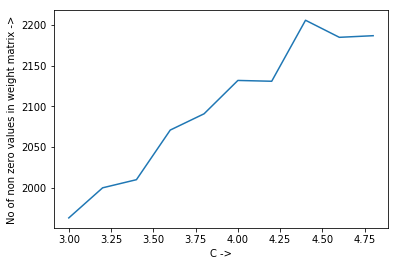

In [40]:
values =list(np.arange(3,5,0.2))
weights =[]
for lambdaa in values:
    lr = LogisticRegression(C=lambdaa , penalty='l1')
    lr.fit(final_bigram_counts[0:5000],Y_train[0:5000])
    weights.append(np.count_nonzero(lr.coef_))
plt.plot(values,weights)
plt.xlabel('C ->')
plt.ylabel('No of non zero values in weight matrix ->')
plt.show()

### Finding value of C for logistic regression with l2 regularization using grid and random search

In [42]:
import warnings
warnings.filterwarnings('ignore')
l1_values = [{'C': [10**-5,10**-4,10**-3,10**-2, 10**0, 10**2,10**-3,10**4]}]
m = GridSearchCV(LogisticRegression(penalty='l2'), l1_values, scoring = 'f1', cv=10)
m.fit(final_bigram_counts[0:20000], Y_train[0:20000])
print(model.best_estimator_)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [43]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {'C': [10**-5,10**-4,10**-3,10**-2, 10**0, 10**2,10**-3,10**4]}
model = RandomizedSearchCV(LogisticRegression(penalty='l2'), param_dist, scoring = 'f1', cv=10,n_iter=2)
model.fit(final_bigram_counts[0:20000], Y_train[0:20000])
print(model.best_estimator_)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


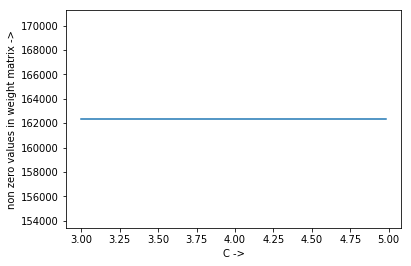

In [44]:
from sklearn.cross_validation import cross_val_score
values =list(np.arange(3,5,0.02))
weights =[]
for lambdaa in values:
    lr = LogisticRegression(C=lambdaa , penalty='l2')
    lr.fit(final_bigram_counts[0:5000],Y_train[0:5000])
    weights.append(np.count_nonzero(lr.coef_))
plt.plot(values,weights)
plt.xlabel('C ->')
plt.ylabel('non zero values in weight matrix ->')
plt.show()

### Multicolliearity in bigrams

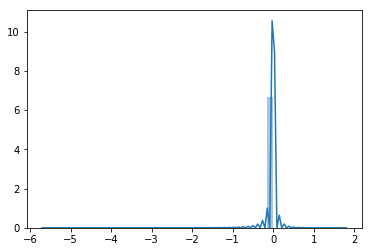

In [63]:
noise = np.random.normal(loc=0.1,scale=0.1,size=50)
noise = noise.reshape(50,1)
noise_counts = final_bigram_counts[0:50] + noise
l1 = LogisticRegression(C=100,penalty='l1')
l1.fit(final_bigram_counts[0:50],Y_train[0:50])
l2 = LogisticRegression(C=100,penalty='l1')
l2.fit(noise_counts,Y_train[0:50])
weights = np.array(l1.coef_)
weight_noise = np.array(l2.coef_)
weight = np.subtract(weights,weight_noise)
sns.distplot(a=weight,kde=True)
plt.show()

### Results on test data and training

In [5]:
from sklearn.metrics import accuracy_score
logisticregression = LogisticRegression(C=100 , penalty='l2')
logisticregression.fit(final_bigram_counts[0:60000],Y_train[0:60000])
pred = logisticregression.predict(final_x_test_counts[0:8000])
score = accuracy_score(Y_test[0:8000],pred)
con = confusion_matrix(Y_test[0:8000],pred)
print('accuracy on test data: ',score*100,"%")
print('confusion matrix')
print(con)

accuracy on test data:  93.4375 %
confusion matrix
[[ 844  385]
 [ 140 6631]]


In [13]:
from sklearn.metrics import accuracy_score
logisticregression = LogisticRegression(C=100 , penalty='l2')
logisticregression.fit(final_bigram_counts[0:60000],Y_train[0:60000])
pred = logisticregression.predict(final_bigram_counts[0:8000])
score = accuracy_score(Y_train[0:8000],pred)
print('accuracy on training data:',score*100)

accuracy on training data: 100.0


### important features

In [16]:
feature_names = count_vect.get_feature_names()
feature_names = np.array(feature_names)
feature = np.vstack((np.absolute(logisticregression.coef_),feature_names))
feature = pd.DataFrame(data=feature.T,columns=('coefficients','words'))
main = feature.sort_values('coefficients', axis=0, ascending=False, inplace=False, kind='quicksort')
print('\t     top 20 features')
print(main[0:20])

	     top 20 features
                  coefficients              words
2275592  9.996259396912024e-05          will tear
545808   9.964483107196995e-05             da bai
324825   9.964483107196995e-05     brewing vessel
636217   9.964483107196995e-05      drink jasmine
1643984  9.964483107196995e-05         rather tea
884171   9.964483107196995e-05         grade just
2332156  9.964483107196995e-05         zhu silver
1592561  9.964483107196995e-05   processed rather
1629463  9.964483107196995e-05  quality typically
12074    9.964483107196995e-05           190º are
425551   9.964483107196995e-05      chinese drink
1553036  9.964483107196995e-05    polyphenols and
1577318  9.964483107196995e-05     prepared video
415878   9.964483107196995e-05      cherished yin
1365440  9.964483107196995e-05          not rishi
875199   9.964483107196995e-05     good infusions
1921211  9.964483107196995e-05  strictly accurate
135953   9.964483107196995e-05       antler amour
1943846  9.964483107196995e-


# [7.2.5] TF-IDF

In [6]:

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(X_train)
final_tfidf_xtest = tf_idf_vect.transform(X_test)

In [ ]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

### Finding best value of C for logistic regression for L1 regularization using randomize and grid search


In [50]:
############# Using grid search #######################
import warnings
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')
logisticregression = LogisticRegression(penalty='l1')
l1_values = [{'C': [10**-5,10**-4,10**-3,10**-2, 10**0, 10**2,10**-3,10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l1'), l1_values, scoring = 'f1', cv=10)
model.fit(final_tf_idf[0:20000], Y_train[0:20000])
print(model.best_estimator_)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [52]:
############# Using random search #######################
import warnings
from sklearn.model_selection import RandomizedSearchCV
warnings.filterwarnings('ignore')
logisticregression = LogisticRegression(penalty='l1')
l1_values = {'C': [10**-5,10**-4,10**-3,10**-2, 10**0, 10**2,10**-3,10**4]}
model = RandomizedSearchCV(LogisticRegression(penalty='l1'), l1_values, scoring = 'f1', cv=10,n_iter =2)
model.fit(final_tf_idf[0:20000], Y_train[0:20000])
print(model.best_estimator_)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


### Finding best value of C for logistic regression for L2 regularization using randomize and grid search


In [53]:
import warnings
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')
logisticregression = LogisticRegression(penalty='l1')
l1_values = [{'C': [10**-5,10**-4,10**-3,10**-2, 10**0, 10**2,10**-3,10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l2'), l1_values, scoring = 'f1', cv=10)
model.fit(final_tf_idf[0:20000], Y_train[0:20000])
print(model.best_estimator_)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [54]:
import warnings
from sklearn.model_selection import RandomizedSearchCV
warnings.filterwarnings('ignore')
logisticregression = LogisticRegression(penalty='l1')
l1_values = {'C': [10**-5,10**-4,10**-3,10**-2, 10**0, 10**2,10**-3,10**4]}
model = RandomizedSearchCV(LogisticRegression(penalty='l2'), l1_values, scoring = 'f1', cv=10,n_iter=5)
model.fit(final_tf_idf[0:20000], Y_train[0:20000])
print(model.best_estimator_)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


### sparsity in tf_idf using l1 regularization

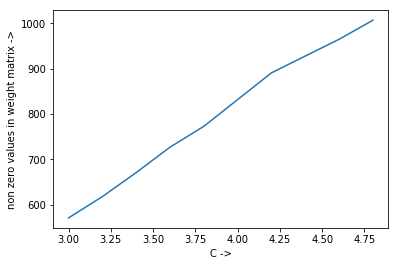

In [56]:
values =list(np.arange(3,5,0.2))
weights =[]
for lambdaa in values:
    lr = LogisticRegression(C=lambdaa , penalty='l1')
    lr.fit(final_tf_idf[0:10000],Y_train[0:10000])
    weights.append(np.count_nonzero(lr.coef_))
plt.plot(values,weights)
plt.xlabel('C ->')
plt.ylabel('non zero values in weight matrix ->')
plt.show()

### Multicolinearity

E:\anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


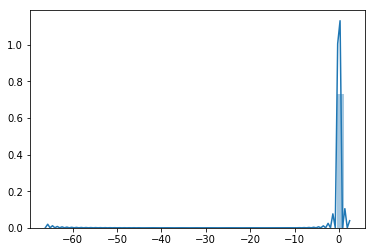

In [ ]:
noise = np.random.normal(loc=0.1,scale=0.1,size=100)
noise = noise.reshape(100,1)
noise_counts = final_tf_idf[0:100] + noise
l1 = LogisticRegression(C=100,penalty='l1')
l1.fit(final_tf_idf[0:100],Y_train[0:100])
l2 = LogisticRegression(C=100,penalty='l1')
l2.fit(noise_counts,Y_train[0:100])
weights = np.array(l1.coef_)
weight_noise = np.array(l2.coef_)
weight = np.subtract(weights,weight_noise)
sns.distplot(a=weight,kde=True)
plt.show()

### Logistic regression on tf_idf

In [7]:

model = LogisticRegression(C=100,penalty='l1')
model.fit(final_tf_idf[0:40000],Y_train[0:40000])
pred = model.predict(final_tfidf_xtest[0:8000])
acc = accuracy_score(Y_test[0:8000],pred)
con = confusion_matrix(Y_test[0:8000],pred)
print('accuracy on test data: ',acc*100,"%")
print('confusion matrix')
print(con)

accuracy on test data:  92.35 %
confusion matrix
[[ 850  379]
 [ 233 6538]]


In [16]:
model = LogisticRegression(C=100,penalty='l1')
model.fit(final_tf_idf[0:40000],Y_train[0:40000])
pred = model.predict(final_tf_idf[0:8000])
acc = accuracy_score(Y_train[0:8000],pred)
print('accuracy on training data',acc*100)

accuracy on training data 100.0


In [11]:
features = tf_idf_vect.get_feature_names()
feature = np.array(features).reshape(1,2334136)
features = np.vstack((features,np.absolute(model.coef_)))
features = pd.DataFrame(data=features.T,columns=('words','coefficients'))
main = features.sort_values('coefficients',axis=0,inplace=False,ascending=False,kind='quicksort')
print('\t top tf_idf features ')
print(main[0:20])

	 top tf_idf features 
                   words       coefficients
2148495        two stars   97.9387260253721
1205694          made to  9.992420304074347
2029466       the review  9.973709247692597
343788          but even   9.97314533067166
2026911        the packs   9.96336482442249
2202588       very small   9.95667805898776
223568      basket there  9.954847333919703
1648992         reaching  9.949019819561725
1062474      is superior   9.94171827902475
1123370         labrador  9.935053326273662
2112711             tore  9.910003726772635
171875              asia  9.899350184321259
708753        excited to  9.888249684271434
951909             heart  9.884955287146006
124523       and regular  9.884886503726616
474069    competing with  9.880227633262846
1399722     of starbucks  9.869608609329159
884765   graham crackers  9.866239922907917
1656256           reason  9.863324226840845
1067001            it 20  9.852678373606427


# [7.2.6] Word2Vec

In [ ]:
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)



In [ ]:
model.wv['computer']


In [ ]:
model.wv.similarity('woman', 'man')

In [ ]:
model.wv.most_similar('woman')

In [ ]:
model.wv.most_similar('tasti')  # "tasti" is the stemmed word for tasty, tastful

In [ ]:
model.wv.most_similar('tasty') 


In [ ]:
model.wv.similarity('tasty', 'tast')


In [20]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [18]:
import gensim
i=0
list_of_xtest=[]
for sent in X_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_xtest.append(filtered_sentence)

In [21]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    


# [7.2.7] Avg W2V, TFIDF-W2V

In [22]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

254919
50


In [23]:
sent_vectors_xtest = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_xtest.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

254919
50


In [24]:
sent_vectors_xtest[0]

array([ 0.15092915,  0.14080188,  0.66434981,  0.57944964, -0.7605812 ,
        0.12812622, -1.03753508,  0.86830288,  1.36076263, -0.50552056,
        1.00935305,  0.43042674,  1.12840555,  0.62389162,  0.10140032,
       -0.15916383,  0.02674587,  0.34111015, -0.24381049,  0.0439647 ,
        0.29637141, -0.14694298,  0.77579346,  0.67065887,  2.074147  ,
        0.01195426,  0.60455836, -0.66730112, -0.98252906,  0.46688718,
        0.46805748, -0.17625452,  0.63541007,  1.10014726, -0.91586172,
       -0.4061644 ,  0.59801122,  0.08968659,  0.3667628 , -0.05420152,
        1.48605563,  0.48561127,  0.10318322, -0.29416576,  0.54168012,
       -0.0681733 ,  0.50263586,  0.57150307, -1.30010271,  0.16003207])

### Finding best C using  for L1 regularization using grid and random search

In [25]:
import warnings
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')
logisticregression = LogisticRegression(penalty='l1')
l1_values = [{'C': [10**-5,10**-4,10**-3,10**-2, 10**0, 10**2,10**-3,10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l1'), l1_values, scoring = 'f1', cv=10)
model.fit(sent_vectors[0:20000], Y_train[0:20000])
print(model.best_estimator_)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [20]:
import warnings
from sklearn.model_selection import RandomizedSearchCV
warnings.filterwarnings('ignore')
logisticregression = LogisticRegression(penalty='l1')
l1_values = {'C': [10**-5,10**4]}
model = RandomizedSearchCV(LogisticRegression(penalty='l1'), l1_values, scoring = 'f1', cv=10,n_iter=2)
model.fit(sent_vectors[0:20000], Y_train[0:20000])
print(model.best_estimator_)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


### Finding best C  for L2 regularization using Grid and random search

In [22]:
import warnings
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')
l1_values = [{'C': [10**-5,10**-4,10**-3,10**-2, 10**0, 10**2,10**-3,10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l2'), l1_values, scoring = 'f1', cv=10)
model.fit(sent_vectors[0:20000], Y_train[0:20000])
print(model.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [25]:
l1_values = {'C': [10**-5,10**4]}
model = RandomizedSearchCV(LogisticRegression(penalty='l2'), l1_values, scoring = 'f1', cv=10,n_iter=2)
model.fit(sent_vectors[0:20000], Y_train[0:20000])
print(model.best_estimator_)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [27]:
from sklearn.metrics import accuracy_score
logisticregression = LogisticRegression(C=1 , penalty='l2')
logisticregression.fit(sent_vectors[0:90000],Y_train[0:90000])
pred = logisticregression.predict(sent_vectors_xtest[0:20000])
score = accuracy_score(Y_test[0:20000],pred)
con = confusion_matrix(Y_test[0:20000],pred)
print('accuracy on test data: ',score*100,"%")
print('confusion matrix')
print(con)

accuracy on test data:  77.415 %
confusion matrix
[[  300  2851]
 [ 1666 15183]]


In [40]:
sent_vectors = pd.read_csv('sent_xtrain.csv')
logisticregression = LogisticRegression(C=1 , penalty='l2')
logisticregression.fit(sent_vectors[0:90000],Y_train[0:90000])
pred = logisticregression.predict(sent_vectors[0:90000])
score = accuracy_score(Y_train[0:90000],pred)
print('accuracy on training data:',score*100)

accuracy on training data: 84.55222222222221


## tf-idf weighted Word2vec

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    

    

In [ ]:
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_xtest = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_Xtest[0:100]: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = test_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_xtest.append(sent_vec)
    row += 1

### Finding best C  for L1 regularization using grid and random search

In [32]:
l1_values = [{'C': [10**-5,10**-4,10**-3,10**-2, 10**0, 10**2,10**-3,10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l1'), l1_values, scoring = 'f1', cv=10)
model.fit(tf_idf_sent_vectors, Y_train[0:1000])
print(model.best_estimator_)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [43]:
l1_values = {'C': [10**-5,10**-4,10**-3,10**-2, 10**0, 10**2,10**-3,10**4]}
model = RandomizedSearchCV(LogisticRegression(penalty='l1'), l1_values, scoring = 'f1', cv=10,n_iter=5)
model.fit(tf_idf_sent_vectors, Y_train[0:1000])
print(model.best_estimator_)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


### Finding the best C  for L2 regularization using grid and random search

In [44]:
l1_values = [{'C': [10**-5,10**-4,10**-3,10**-2, 10**0, 10**2,10**-3,10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l2'), l1_values, scoring = 'f1', cv=10)
model.fit(tf_idf_sent_vectors, Y_train[0:1000])
print(model.best_estimator_)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [45]:
l1_values = {'C': [10**-5,10**-4,10**-3,10**-2, 10**0, 10**2,10**-3,10**4]}
model = RandomizedSearchCV(LogisticRegression(penalty='l2'), l1_values, scoring = 'f1', cv=10,n_iter=5)
model.fit(tf_idf_sent_vectors, Y_train[0:1000])
print(model.best_estimator_)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [31]:
tf_idf_sent_vectors_xtest = pd.read_csv('tfidf_sent_xtest.csv')
logisticregression = LogisticRegression(C=100 , penalty='l2')
logisticregression.fit(tf_idf_sent_vectors,Y_train[0:1000])
pred = logisticregression.predict(tf_idf_sent_vectors_xtest)
score = accuracy_score(Y_test[0:100],pred)
con = confusion_matrix(Y_test[0:100],pred)
print('accuracy on test data: ',score*100,"%")
print('confusion matrix')
print(con)

accuracy on test data:  84.0 %
confusion matrix
[[ 5 10]
 [ 6 79]]


In [30]:
from sklearn.metrics import accuracy_score
tf_idf_sent_vectors = pd.read_csv('tfidf_sent_xtrain.csv')
logisticregression = LogisticRegression(C=100 , penalty='l2')
logisticregression.fit(tf_idf_sent_vectors,Y_train[0:1000])
pred = logisticregression.predict(tf_idf_sent_vectors)
score = accuracy_score(Y_train[0:1000],pred)
print('accuracy on training data:',score*100)

accuracy on training data: 90.0


## Conclusion and summary

Following step wise approach is used for each type vectorizer and embeddings:-
- Finding Best C for l1 regularization both with grid search and random search
- Sparsity variation with respect to value of C
- Finding Best C for l2 regularization both with grid search and random search
- Multicollinearity check
- Performance on test data
- Performancce on training data
- Top features

### Performance table on training and test data

|   Algorithms     | Bow  | Bigrams  | tf_idf  | avgword2vec  | tfidf_word2vec  |
|------------------|------|----------|---------|--------------|-----------------|
|value of c for L1 | 1    |    100   |    1    |    100       |       100       |
|------------------|------|----------|---------|--------------|-----------------|
|value of c for L2 | 1    |    100   |  100    |     1        |       100       |
|------------------|------|----------|---------|--------------|-----------------|
|   Test accuracy  |90.79 | 93.48    |  92.88  |    77.41     |      84         |
|------------------|------|----------|---------|--------------|-----------------|
|Training accuracy |97.28 |    100   |  100    |    84.38     |      90         |

### Confusion matrix

#### Bow


|1105|462 |
|----|----|
|459 |7914|

#### Bigrams

|844|385 |
|---|----|
|140|6631|

#### tf_idf

|901 |328 |
|----|----|
|241 |6530|

#### Avg word2vec

| 300   | 2851  |
|-------|-------|
|  1666 | 15183 |

#### tf_idf weighted word2vec

|   10   |   5    |
|--------|--------|
|   6    |  79    |